<B><H2> HOUSE PRICE ESTIMATOR </H2></B><H5>TENSORFLOW REGRESSION SEQUENTIAL DNN MODEL</H5>


In [1]:
import docker
import requests
import json
import numpy as np
import pandas as pd



#TENSORFLOW API
import tensorflow as tf
import tensorflow_data_validation as tfdv
# Feature Engineering
from tensorflow import feature_column as fc
from keras.models import Sequential
from keras import layers
from keras import utils
# TF Dataset for input pipeline
import tensorflow_datasets as tfds

# VISUALISATION API
import matplotlib.pyplot as plt
import seaborn as sns # Seaborn is a Python data visualization library based on matplotlib.

# Import train_test_split function from sklearn.model_selection
from sklearn.model_selection import train_test_split

# Used to calculate stats such as Z score, standard deviation etc.
from scipy import stats


2022-07-31 11:20:52.722795: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-31 11:20:52.762003: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-31 11:20:52.762044: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<H5> READ THE DATA INTO PANDAS DATAFRAME.</H5> Remove any NULL values

In [2]:
city = 'Melbourne'

In [3]:
# Import data from CSV into pandas DF
df= pd.read_csv(f"data/{city}/{city}_area.csv")
# Check if there any NULL or NaN values
df.isnull().sum()
# Drop any NA values
df = df.dropna(how='any',axis=0)
# Check that there is no longer Null values
df.isnull().sum()
# Look at DF to get a feel of data
df.head()


,Street,Address,Suburb,State,Postcode,Type,Date,Method,Price,Bedrooms,Bathrooms,Cars,Area,Agent,Latitude,Longitude,Distance
0,413/250 Barkly Street,FOOTSCRAY VIC 3011,FOOTSCRAY,VIC,3011,House,22-Jul-22,private treaty,455,2,1,1,0.0,Sweeney Estate Agents Yarraville,-37.798134,144.897345,6.054337
1,28 Moubray Street,ALBERT PARK VIC 3206,ALBERT PARK,VIC,3206,House,27-Nov-21,auction,2270000,2,1,1,0.0,Marshall White Port Phillip,-37.840971,144.951109,3.158503
2,17 Paul Street,CHELTENHAM VIC 3192,CHELTENHAM,VIC,3192,House,26-Nov-21,auction,2260000,4,2,2,0.0,Buxton Real Estate Mentone,-37.961458,145.047628,17.977853
3,2506/83 Queensbridge Street,SOUTHBANK VIC 3006,SOUTHBANK,VIC,3006,Apartment,6-Jan-22,private treaty,2280000,3,3,2,0.0,MICM Real Estate,-37.825362,144.964020,1.241866
4,1/7 Foam Street,HAMPTON VIC 3188,HAMPTON,VIC,3188,House,20-Nov-21,auction,2262000,4,2,2,0.0,Marshall White Port Phillip,-37.937024,145.006746,14.185577


In [ ]:
# df['Date']= df['Date'].astype('datetime64[ns]')
# df['Year'] = df['Date'].dt.year
# df.to_csv(f"data/{city}/{city}_year.csv",index = False)

In [ ]:
df.info()

<h5> 1. Define Numeric, Categorical & Features that need to be dropped
<h5> 2. Performing ONE HOT ENCODING on CATEGORICAL features
<h5> 3. Drop unwanted features </h5>




In [4]:
# Above there is a combination of categorical & numerical features with 'Price' being the label. We will need to classify the 
# features into the following:
drop_cat = False

num_feat = ['Bedrooms','Bathrooms','Cars','Area','Latitude','Longitude','Distance']
cat_feat = ['Suburb','Type','Method']
drop_feat = ['Street','Address','State','Postcode','Agent','Date']

# Drop features that are not required
if set(drop_feat).issubset(df.columns):
  df = df.drop(drop_feat, axis = 1)
  if drop_cat:
    if set(cat_feat).issubset(df.columns):
      df = df.drop(cat_feat, axis = 1)
  else:
     for feat in cat_feat:
       dummy = pd.get_dummies(df[feat], prefix=feat)
       df = pd.merge(left=df,right=dummy,left_index=True,right_index=True,)
     df = df.drop(cat_feat, axis = 1)



df.head()

,Price,Bedrooms,Bathrooms,Cars,Area,Latitude,Longitude,Distance,Suburb_ABBOTSFORD,Suburb_ABERFELDIE,...,Type_Penthouse,Type_Retirement Living,Type_Semi-detached,Type_Studio,Type_Terrace,Type_Townhouse,Type_Villa,Method_Another Method,Method_auction,Method_private treaty
0,455,2,1,1,0.0,-37.798134,144.897345,6.054337,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2270000,2,1,1,0.0,-37.840971,144.951109,3.158503,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2260000,4,2,2,0.0,-37.961458,145.047628,17.977853,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2280000,3,3,2,0.0,-37.825362,144.964020,1.241866,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2262000,4,2,2,0.0,-37.937024,145.006746,14.185577,0,0,...,0,0,0,0,0,0,0,0,1,0


<H4> EXPLORATORY DATA ANALYSIS (EDA) </H4>

Explore Relationships between Numerical Features & Price (label)

In [ ]:
sns.pairplot(data = df, y_vars= ['Price'], x_vars = num_feat)

Using Pandas statistics to look for Outliers

Filter out Outliers using either Z Score Method (normal discribution) or IQR method.

In [5]:
method = 'Zscore'
# Interquartile range (IQR) method should be used for NON normal distribution

def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

if method == 'Zscore':
  #df = df[(np.abs(stats.zscore(df['Price'])) < 3)]
  df = df[(np.abs(stats.zscore(df[num_feat])) < 3).all(axis=1)]
  
else:
  remove_outlier(df, num_feat)


Confirm that Outliers have been removed

In [6]:
df.describe()

,Price,Bedrooms,Bathrooms,Cars,Area,Latitude,Longitude,Distance,Suburb_ABBOTSFORD,Suburb_ABERFELDIE,...,Type_Penthouse,Type_Retirement Living,Type_Semi-detached,Type_Studio,Type_Terrace,Type_Townhouse,Type_Villa,Method_Another Method,Method_auction,Method_private treaty
count,5.772900e+04,57729.000000,57729.000000,57729.000000,57729.000000,57729.000000,57729.000000,57729.000000,57729.000000,57729.000000,...,57729.000000,57729.000000,57729.000000,57729.000000,57729.000000,57729.000000,57729.000000,57729.000000,57729.000000,57729.000000
mean,1.293355e+06,3.207972,1.832978,1.812521,711.757158,-37.902487,144.938660,22.936759,0.003239,0.001750,...,0.000017,0.000520,0.000294,0.002997,0.000277,0.126834,0.002339,0.000381,0.396820,0.602799
std,8.191022e+05,1.047572,0.735700,0.969979,5720.348997,0.184148,0.219551,19.120698,0.056823,0.041791,...,0.004162,0.022791,0.017158,0.054661,0.016646,0.332790,0.048302,0.019518,0.489242,0.489322
min,1.000000e+00,0.000000,0.000000,0.000000,0.000000,-38.473942,144.273302,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.600000e+05,3.000000,1.000000,1.000000,0.000000,-37.985158,144.887182,8.208148,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.180000e+06,3.000000,2.000000,2.000000,155.000000,-37.866931,144.995388,16.190978,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.760000e+06,4.000000,2.000000,2.000000,613.000000,-37.773433,145.062168,34.768108,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,6.200000e+06,6.000000,4.000000,5.000000,250900.000000,-37.329765,145.496068,77.507458,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


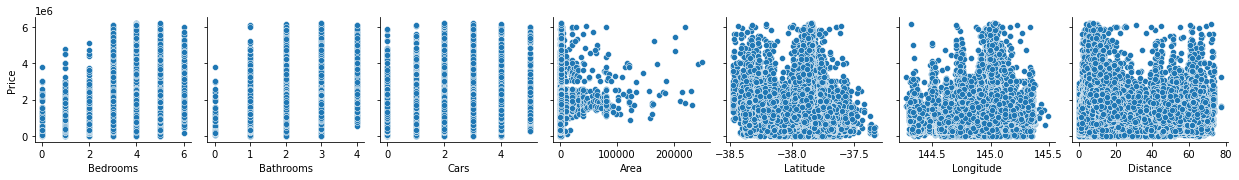

In [7]:
sns.pairplot(data = df,y_vars=['Price'],x_vars=num_feat)

<H4> Plot of Lattitude & longitude showing pricing in each location</H4>
Observe that suburbs closer to the city centre generally are more expensive

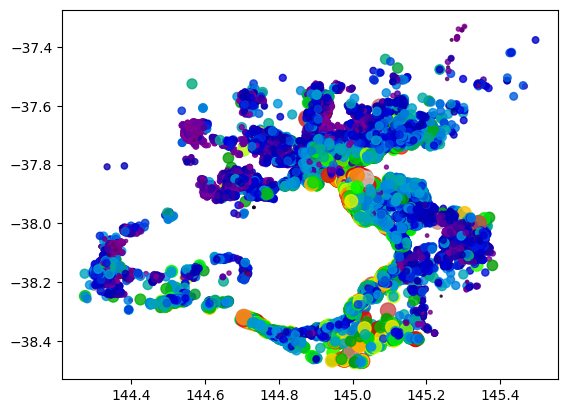

In [8]:
plt.scatter(x = df['Longitude'], y = df['Latitude'],c =df['Price'],alpha=0.8,s=df['Price']/50000,cmap='nipy_spectral' )

Data Splitting into TRAIN,VALIDATION & TEST DF using Scikit Learn function

In [9]:
# Let's split the dataset into train, validation, and test sets as Pandas DF format
train, test = train_test_split(df, test_size=0.2,random_state=42)
train, val = train_test_split(train, test_size=0.2,random_state=42)

print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

36946 train examples
9237 validation examples
11546 test examples


Defining a normalization/scaling function to be used for numerical features

In [10]:
def normalize(df):
    result = df.copy()
    for feature_name in num_feat:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

Normalizing the Training Data,Valuation & test Numerical Features

In [11]:
X_train = normalize(train.drop(['Price'], axis =1))
Y_train = train['Price']

X_test = normalize(test.drop(['Price'], axis =1))
Y_test = test['Price']

X_val = normalize(val.drop(['Price'], axis =1))
Y_val = val['Price']


<h3> Defining & Training a Tensorflow Sequential Regression DNN model.</h3>

In [12]:
# Model create

# `tf.keras.Sequential()` groups a linear stack of layers into a tf.keras.Model.
model = tf.keras.Sequential([
  layers.Dense(256, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(1, activation='linear',  name='Price')
])

# Model compile
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

# Model Fit
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=20)



2022-07-31 11:22:12.300590: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-31 11:22:12.301470: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-31 11:22:12.302109: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-MM57QPP): /proc/driver/nvidia/version does not exist
2022-07-31 11:22:12.308691: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
1155/1155 [==============================] - 7s 5ms/step - loss: 939647893504.0000 - mse: 939647893504.0000 - val_loss: 384430702592.0000 - val_mse: 384430702592.0000
Epoch 2/20
1155/1155 [==============================] - 5s 4ms/step - loss: 317235429376.0000 - mse: 317235429376.0000 - val_loss: 246643998720.0000 - val_mse: 246643998720.0000
Epoch 3/20
1155/1155 [==============================] - 5s 4ms/step - loss: 214269313024.0000 - mse: 214269313024.0000 - val_loss: 198883835904.0000 - val_mse: 198883835904.0000
Epoch 4/20
1155/1155 [==============================] - 5s 4ms/step - loss: 188463529984.0000 - mse: 188463529984.0000 - val_loss: 185264226304.0000 - val_mse: 185264226304.0000
Epoch 5/20
1155/1155 [==============================] - 5s 4ms/step - loss: 179389595648.0000 - mse: 179389595648.0000 - val_loss: 180203388928.0000 - val_mse: 180203388928.0000
Epoch 6/20
1155/1155 [==============================] - 5s 4ms/step - loss: 174508965888.0000 - mse: 174508965

<h4> Evaluating trained model performance using EVALUATION data </h4>

In [13]:
loss, mse = model.evaluate(X_val,Y_val)
print("Mean Squared Error", mse)
print("Root MEAN SQUARE ERROR $",np.sqrt(mse))

289/289 [==============================] - 2s 5ms/step - loss: 169754755072.0000 - mse: 169754755072.0000
Mean Squared Error 169754755072.0
Root MEAN SQUARE ERROR $ 412013.05206510145


<h4> PLOTTING OF LOSS/MSE for TRAINING & EVALUATION DATA  </h4>
Useful to determine underfitting/overfitting as well as optimal number of epcochs for training

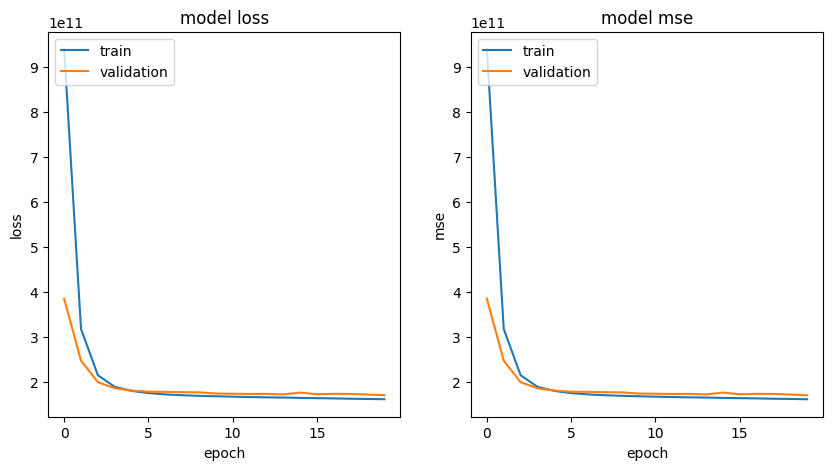

In [14]:
# Use matplotlib to draw the model's loss curves for training and validation
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):  
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left');

# Plotting
plot_curves(history, ['loss', 'mse'])

<H3> PREDICTION </H3>
<h4>Using TEST data to make PRICE prediction & compare ACTUAL vs PREDICTED</h4>
 

361/361 [==============================] - 1s 3ms/step
PREDICTION: $1833441.0   ACTUAL: 1320000 DIFFERENCE: $513.441
PREDICTION: $851905.9375   ACTUAL: 896000 DIFFERENCE: $-44.0940625
PREDICTION: $513003.53125   ACTUAL: 500000 DIFFERENCE: $13.00353125
PREDICTION: $1070903.125   ACTUAL: 1300000 DIFFERENCE: $-229.096875
PREDICTION: $1335415.5   ACTUAL: 1550000 DIFFERENCE: $-214.5845
PREDICTION: $1094728.125   ACTUAL: 1263000 DIFFERENCE: $-168.271875
PREDICTION: $2480882.0   ACTUAL: 1950000 DIFFERENCE: $530.882
PREDICTION: $1310969.75   ACTUAL: 1135000 DIFFERENCE: $175.96975
PREDICTION: $2293947.5   ACTUAL: 1947500 DIFFERENCE: $346.4475
PREDICTION: $2433800.5   ACTUAL: 2515000 DIFFERENCE: $-81.1995
PREDICTION: $621914.9375   ACTUAL: 615000 DIFFERENCE: $6.9149375
PREDICTION: $856053.3125   ACTUAL: 1275000 DIFFERENCE: $-418.9466875
PREDICTION: $530012.9375   ACTUAL: 500000 DIFFERENCE: $30.0129375
PREDICTION: $476888.34375   ACTUAL: 430000 DIFFERENCE: $46.88834375
PREDICTION: $353932.78125  

Text(0, 0.5, 'PREDICATED PRICE: $')

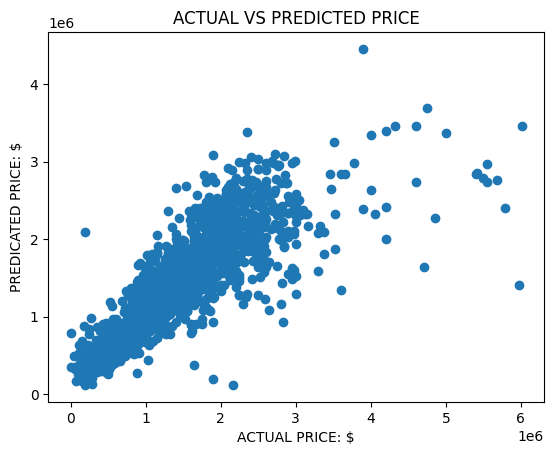

In [15]:
predictions = model.predict(X_test)

#
for i in range(50):
    diff = (predictions[i][0] - test['Price'].iloc[i])/1000
    print('PREDICTION: ${0}'.format(predictions[i][0]) + '   ACTUAL: '+format(test['Price'].iloc[i]) + f' DIFFERENCE: ${diff}')



plt.scatter(Y_test.iloc[0:2000],predictions[0:2000])
plt.title("ACTUAL VS PREDICTED PRICE")
plt.xlabel("ACTUAL PRICE: $")
plt.ylabel("PREDICATED PRICE: $")

<h5> SAVE MODEL </h5>

In [16]:
model.save("saved_models/1")

INFO:tensorflow:Assets written to: saved_models/1/assets


<h4> SERVE MODEL</h4>
<h5> RUN TF SERVING DOCKER CONTAINER </h5>

In [ ]:
#docker run -it -v /home/khaled/AUTOMATION-EXCEL\:/tf_serving -p 8601:8601 --entrypoint /bin/bash tensorflow/serving
#tensorflow_model_server --rest_api_port=8601 --model_name=melb_price --model_base_path=/tf_serving/saved_models/

client = docker.from_env()
container = client.containers.run(image = "tensorflow/serving", ports = {8601:8601},volumes = ['/home/khaled/MLrealestate:/tf_serving'], detach=True)
container.exec_run('/bin/bash')
print(container.exec_run('ls'))
container.exec_run('tensorflow_model_server --rest_api_port=8601 --model_name=real_estate_price_est --model_base_path=/tf_serving/saved_models/',detach = True)

In [ ]:
input = X_test.to_numpy().tolist()[0:5]

data = {"instances": input}
test.head(5)


<h4> API CALL FOR PREDICTION</h4>
<h5>  REST API POST for LOCAL TF SERVING CONTAINER - MODEL NAME: real_estate_est</h5>

In [ ]:
#%%bash
#curl -d '{"instances": [[0.25,0.07553956834532373,0.0,0.25,0.0,0.1937046004842615,0.9103448275862069,0.516068393160683,0.4633053471477789,1.0]]}' \
#-X POST http://localhost:8601/v1/models/melb_price:predict

r = requests.post(url="http://localhost:8601/v1/models/real_estate_price_est:predict", data=json.dumps(data))
print(r.json())

In [ ]:
df= pd.read_csv('data/{city}/{city}_area.csv')
#len(df['Suburb'].unique())
df = df.drop_duplicates(subset=['Suburb','Type','Method'], keep='last')
df.to_csv('data/{city}/{city}_template.csv',index = False)
df.info()
#df.head(20)

In [ ]:
%%bash
heroku container:login
heroku container:push web -a tf-serve-model
heroku container:release web -a tf-serve-model
heroku logs -a tf-serve-model --tail